In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%load_ext autoreload
%autoreload 2
from __future__ import print_function
import os
import argparse
import torch
import torch.utils as tutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torchvision.utils as tvutils
import sys
import glob
import random
sys.path.append(".")
from models.naive_dcgan import *
#from LSTM import LSTM
use_cuda = torch.cuda.is_available()

    # Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

torch.cuda.is_available()

CUDA is supported


True

In [2]:
dataset_root = "./dataset/"
image_size = 64
batch_size = 64
num_workers = 4
num_gf = 64
num_df = 64
epochs = 25
num_row = 8
nrow=num_row
n_sample_per_n_batches = 100
z_dim = 100
num_channels = 3
num_gpu = 1
use_cuda = True
device = torch.device("cuda:0")
l_r = 0.0005
beta1 = 0.5
output_dir = "./results"
netG_path = ""
netD_path = ""

In [3]:
try:
    os.makedirs(output_dir)
except OSError:
    pass
dataset = datasets.ImageFolder(dataset_root, transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))
print(len(dataset))
assert dataset
dataloader = tutils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


2000


In [4]:
for i,data in enumerate(dataloader,0):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [5]:
generator = Generator(z_dim, num_gf, num_channels, use_cuda, num_gpu)
discriminator = Discriminator(num_channels, num_df, use_cuda, num_gpu)
# move generator and disciminator to cuda device if cuda is activated
generator.to(device)
discriminator.to(device)

# init weights of  g and d

generator.apply(init_weights)
discriminator.apply(init_weights)

# load net state if exists
if netG_path != "":
    generator.load_state_dict(torch.load(netG_path))
if netD_path != "":
    discriminator.load_state_dict(torch.load(netD_path))

print("Generator Info:")
print(generator)
print("Discriminator Info:")
print(discriminator)

criteria = nn.BCELoss()

# every time we will use this to sample from generator, so that we can compare the performance of training
sample_batch_z = torch.randn(batch_size, z_dim, 1, 1).to(device)

label_real = 1
label_fake = 0

optim_G = optim.Adam(generator.parameters(), lr=l_r,
                     betas=(beta1, 0.999))
optim_D = optim.Adam(discriminator.parameters(),
                     lr=l_r*0.5, betas=(beta1, 0.999))



Generator Info:
Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
Discr

In [11]:
def plot(D_real_loss,D_fake_loss,G_loss,st):
    plt.figure(figsize=(7, 4))
    #plt.title("test loss with epoches ")
    plt.ylabel('loss')
    plt.xlabel('batch')
    plt.plot(D_real_loss, label='real_loss', color='red')
    plt.plot(D_fake_loss,label='fake_loss',color = 'green')
    plt.plot(G_loss, label='G_loss', color='blue')
    plt.legend()
    plt.grid()
    plt.savefig(output_dir+'/'+st)
    plt.show()

In [10]:
plt.savefig?

In [12]:
D_fake_loss = []
D_real_loss = []
G_loss = []

def train(epochs):
    for epoch in range(epochs):
        real_loss = []
        fake_loss = []
        total_loss = []
        G_batch_loss = []
        
        for i, data in enumerate(dataloader, 0):
            # first update discriminator's parameters
            # max(log(D(x))+log(1-D(G(z))))
            # ------------------------------
            # first train for real images

            # zero grad
            discriminator.zero_grad()
            real_batch_data = data[0].to(device)
            batch_size = real_batch_data.size(0)
            batch_labels = torch.full((batch_size,), label_real, device=device)
            # forward to get output of D for real images
            real_batch_output = discriminator(real_batch_data)
            # compute loss for D_real
            loss_D_real = criteria(real_batch_output, batch_labels)
            # backward the gradients
            loss_D_real.backward()

            loss_D_real_mean = loss_D_real.mean().item()
            D_real_loss.append(loss_D_real_mean)
            real_loss.append(loss_D_real_mean)

            # now we train with fake images generated by G
            # first sample from latent variable z
            fake_batch_z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            # then generate fake images
            fake_batch_images = generator(fake_batch_z)
            # generate fake labels
            batch_labels.fill_(label_fake)
            # forward D to get output
            # !这里使用detach,是为了防止判别网络通过生成网络的输出值拷贝改变其值,进而影响生成网络的梯度计算
            fake_batch_output = discriminator(fake_batch_images.detach())
            # compute loss of D for fake images
            loss_D_fake = criteria(fake_batch_output, batch_labels)
            # backward
            loss_D_fake.backward()

            loss_D_fake_mean = loss_D_fake.mean().item()
            D_fake_loss.append(loss_D_fake_mean)
            fake_loss.append(loss_D_fake_mean)

            loss_D_total = loss_D_fake + loss_D_real
            total_loss.append(loss_D_total)

            # update G parameters
            optim_D.step()

            # now it's G's turn
            # ---------------------------------
            # let's maximize logD(G(z))
            generator.zero_grad()
            # mark label real for G
            batch_labels.fill_(label_real)
            # 我们需要判别网络更新之后的判别结果,就像银行知道了假币的缺陷,那么制造假币的需要知道银行掌握的信息(判据)
            batch_output_G = discriminator(fake_batch_images)
            # compute loss for G
            loss_G = criteria(batch_output_G, batch_labels)
            # compute gradient for G
            loss_G.backward()

            loss_G_mean = loss_G.mean().item()
            G_loss.append(loss_G_mean)
            G_batch_loss.append(loss_G_mean)

            # update parameters for G
            optim_G.step()

            print("epoch:{}/{},n_batch:{}/{},loss_real_D:{:.4},loss_fake_D:{:.4},loss_G:{:.4}".format(
                epoch, epochs, i, len(dataloader), loss_D_real_mean, loss_D_fake_mean, loss_G_mean))

            if i % n_sample_per_n_batches == 0:
                # sample every 100 batch
                tvutils.save_image(
                    real_batch_data, "%s/sample_real.png" % output_dir, nrow=nrow,normalize=True)
                fake_batch_images = generator(sample_batch_z)
                tvutils.save_image(fake_batch_images.detach(), "%s/sample_fake_images_epoch%03d_%s.png" %
                                   (output_dir, epoch,'test'),nrow=nrow, normalize=False)

        torch.save(discriminator.state_dict(),
                   "%s/discriminator_epoch_%03d.pth" % (output_dir, epoch))
        torch.save(generator.state_dict(),
                   "%s/generator_epoch_%03d.pth" % (output_dir, epoch))
        plot(real_loss,fake_loss,G_loss,"loss_epoch%03d_%s"%(epoch,'test'))


In [8]:
tvutils.save_image?

epoch:0/25,n_batch:0/32,loss_real_D:0.388,loss_fake_D:0.1503,loss_G:2.836
epoch:0/25,n_batch:1/32,loss_real_D:0.7793,loss_fake_D:0.2063,loss_G:0.8177
epoch:0/25,n_batch:2/32,loss_real_D:0.101,loss_fake_D:1.065,loss_G:3.009
epoch:0/25,n_batch:3/32,loss_real_D:0.4449,loss_fake_D:0.1642,loss_G:2.805
epoch:0/25,n_batch:4/32,loss_real_D:0.6183,loss_fake_D:0.2885,loss_G:1.239
epoch:0/25,n_batch:5/32,loss_real_D:0.2212,loss_fake_D:0.7754,loss_G:2.733
epoch:0/25,n_batch:6/32,loss_real_D:0.5668,loss_fake_D:0.2657,loss_G:1.865
epoch:0/25,n_batch:7/32,loss_real_D:0.3171,loss_fake_D:0.5184,loss_G:2.486
epoch:0/25,n_batch:8/32,loss_real_D:0.4764,loss_fake_D:0.2508,loss_G:1.962
epoch:0/25,n_batch:9/32,loss_real_D:0.3246,loss_fake_D:0.3265,loss_G:2.183
epoch:0/25,n_batch:10/32,loss_real_D:0.3938,loss_fake_D:0.2992,loss_G:2.455
epoch:0/25,n_batch:11/32,loss_real_D:0.3458,loss_fake_D:0.3037,loss_G:2.266
epoch:0/25,n_batch:12/32,loss_real_D:0.3387,loss_fake_D:0.2591,loss_G:2.099
epoch:0/25,n_batch:13/32

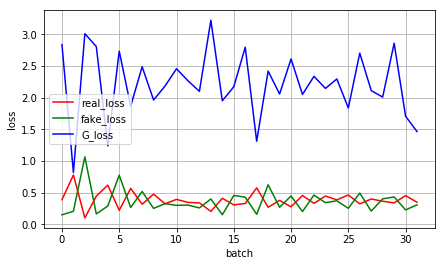

epoch:1/25,n_batch:0/32,loss_real_D:0.141,loss_fake_D:0.8467,loss_G:4.716
epoch:1/25,n_batch:1/32,loss_real_D:1.267,loss_fake_D:0.08169,loss_G:0.976
epoch:1/25,n_batch:2/32,loss_real_D:0.07007,loss_fake_D:1.284,loss_G:4.262
epoch:1/25,n_batch:3/32,loss_real_D:0.9755,loss_fake_D:0.04804,loss_G:1.87
epoch:1/25,n_batch:4/32,loss_real_D:0.18,loss_fake_D:0.6024,loss_G:2.54
epoch:1/25,n_batch:5/32,loss_real_D:0.548,loss_fake_D:0.2922,loss_G:1.965
epoch:1/25,n_batch:6/32,loss_real_D:0.5767,loss_fake_D:0.4055,loss_G:1.634
epoch:1/25,n_batch:7/32,loss_real_D:0.4654,loss_fake_D:0.5827,loss_G:2.455
epoch:1/25,n_batch:8/32,loss_real_D:0.2997,loss_fake_D:0.3271,loss_G:2.91
epoch:1/25,n_batch:9/32,loss_real_D:0.4969,loss_fake_D:0.1687,loss_G:1.577
epoch:1/25,n_batch:10/32,loss_real_D:0.2767,loss_fake_D:0.908,loss_G:3.369
epoch:1/25,n_batch:11/32,loss_real_D:0.6865,loss_fake_D:0.1161,loss_G:1.657
epoch:1/25,n_batch:12/32,loss_real_D:0.1802,loss_fake_D:0.66,loss_G:3.16
epoch:1/25,n_batch:13/32,loss_re

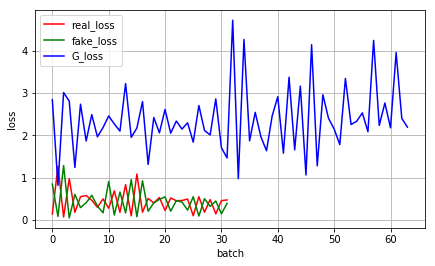

epoch:2/25,n_batch:0/32,loss_real_D:0.08127,loss_fake_D:0.9537,loss_G:4.629
epoch:2/25,n_batch:1/32,loss_real_D:1.136,loss_fake_D:0.07524,loss_G:1.758
epoch:2/25,n_batch:2/32,loss_real_D:0.1505,loss_fake_D:0.6339,loss_G:3.582
epoch:2/25,n_batch:3/32,loss_real_D:0.5888,loss_fake_D:0.1746,loss_G:2.385
epoch:2/25,n_batch:4/32,loss_real_D:0.3902,loss_fake_D:0.3477,loss_G:2.074
epoch:2/25,n_batch:5/32,loss_real_D:0.2765,loss_fake_D:0.3993,loss_G:3.368
epoch:2/25,n_batch:6/32,loss_real_D:0.5041,loss_fake_D:0.188,loss_G:1.812
epoch:2/25,n_batch:7/32,loss_real_D:0.224,loss_fake_D:0.5644,loss_G:3.463
epoch:2/25,n_batch:8/32,loss_real_D:0.7681,loss_fake_D:0.1972,loss_G:1.222
epoch:2/25,n_batch:9/32,loss_real_D:0.2417,loss_fake_D:0.8625,loss_G:3.205
epoch:2/25,n_batch:10/32,loss_real_D:0.776,loss_fake_D:0.1986,loss_G:1.262
epoch:2/25,n_batch:11/32,loss_real_D:0.2297,loss_fake_D:0.7982,loss_G:3.403
epoch:2/25,n_batch:12/32,loss_real_D:0.7391,loss_fake_D:0.1224,loss_G:1.55
epoch:2/25,n_batch:13/32,

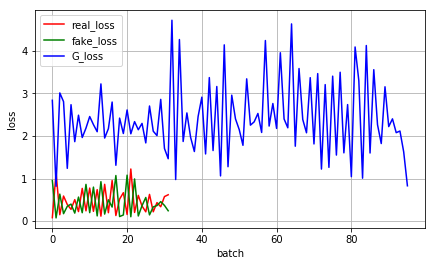

epoch:3/25,n_batch:0/32,loss_real_D:0.07897,loss_fake_D:1.441,loss_G:5.288
epoch:3/25,n_batch:1/32,loss_real_D:1.686,loss_fake_D:0.03237,loss_G:1.25
epoch:3/25,n_batch:2/32,loss_real_D:0.09864,loss_fake_D:0.9589,loss_G:3.17
epoch:3/25,n_batch:3/32,loss_real_D:0.5879,loss_fake_D:0.1555,loss_G:2.217
epoch:3/25,n_batch:4/32,loss_real_D:0.3256,loss_fake_D:0.338,loss_G:1.832
epoch:3/25,n_batch:5/32,loss_real_D:0.2183,loss_fake_D:0.6867,loss_G:3.44
epoch:3/25,n_batch:6/32,loss_real_D:1.196,loss_fake_D:0.1198,loss_G:0.6878
epoch:3/25,n_batch:7/32,loss_real_D:0.08513,loss_fake_D:1.324,loss_G:4.223
epoch:3/25,n_batch:8/32,loss_real_D:1.754,loss_fake_D:0.07388,loss_G:1.034
epoch:3/25,n_batch:9/32,loss_real_D:0.2333,loss_fake_D:1.196,loss_G:2.875
epoch:3/25,n_batch:10/32,loss_real_D:0.5675,loss_fake_D:0.2212,loss_G:2.052
epoch:3/25,n_batch:11/32,loss_real_D:0.1723,loss_fake_D:0.3288,loss_G:2.594
epoch:3/25,n_batch:12/32,loss_real_D:0.6118,loss_fake_D:0.3309,loss_G:1.393
epoch:3/25,n_batch:13/32,l

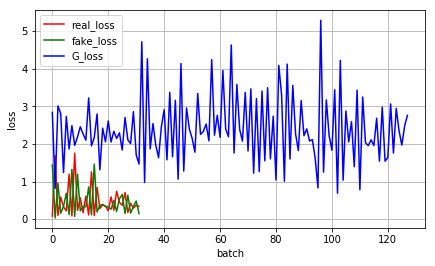

epoch:4/25,n_batch:0/32,loss_real_D:0.4171,loss_fake_D:0.494,loss_G:1.69
epoch:4/25,n_batch:1/32,loss_real_D:0.3067,loss_fake_D:0.6641,loss_G:2.848
epoch:4/25,n_batch:2/32,loss_real_D:0.8517,loss_fake_D:0.2759,loss_G:1.042
epoch:4/25,n_batch:3/32,loss_real_D:0.07808,loss_fake_D:1.078,loss_G:3.675
epoch:4/25,n_batch:4/32,loss_real_D:1.289,loss_fake_D:0.1232,loss_G:1.057
epoch:4/25,n_batch:5/32,loss_real_D:0.1332,loss_fake_D:0.7125,loss_G:2.814
epoch:4/25,n_batch:6/32,loss_real_D:0.4376,loss_fake_D:0.3554,loss_G:2.757
epoch:4/25,n_batch:7/32,loss_real_D:0.9172,loss_fake_D:0.2515,loss_G:1.08
epoch:4/25,n_batch:8/32,loss_real_D:0.1347,loss_fake_D:0.8575,loss_G:2.998
epoch:4/25,n_batch:9/32,loss_real_D:0.6962,loss_fake_D:0.2567,loss_G:1.746
epoch:4/25,n_batch:10/32,loss_real_D:0.1855,loss_fake_D:0.5511,loss_G:3.022
epoch:4/25,n_batch:11/32,loss_real_D:0.5764,loss_fake_D:0.2102,loss_G:1.808
epoch:4/25,n_batch:12/32,loss_real_D:0.2646,loss_fake_D:0.5175,loss_G:2.597
epoch:4/25,n_batch:13/32,l

KeyboardInterrupt: 

In [13]:
train(epochs)